**Author: Akash Kharita**
- PhD Candidate, University of Washington
- Date: 5/19/2024

In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 



from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel


import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
sys.path.append('../common_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from tsfel import time_series_features_extractor, get_features_by_domain
from datetime import timedelta
import os


from common_processing_functions import apply_cosine_taper
from common_processing_functions import butterworth_filter
from common_processing_functions import plot_confusion_matrix
from common_processing_functions import plot_classification_report
from common_processing_functions import interquartile

import pickle
from zenodo_get import zenodo_get

#import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Downloading the extracted features

First we will download the features that are extracted from over 200k events and are stored in a zenodo repository. The features were downloaded from 150s waveforms (50s before and 100s after the origin time/first arrival), the choice of window length was made after experimenting with various window sizes. 

Following processing is involved before feature extraction. 
- Resampling to 100 Hz
- Detrend
- Butterworth bandpass four corner filter (1-10 Hz)
- Normalization




## Tsfel Features

For each processed waveform, we extract tsfel features. Tsfel is a time series feature extraction library that extracts 390 features in time, frequency and spectrogram domain. More information about these features can be found here - https://tsfel.readthedocs.io/en/latest/. In seismology, these features have been used for the case study of discrimination of low magnitude earthquakes from icequakes (Kharita et al. 2024). Check this out! - https://academic.oup.com/gji/article/237/2/1189/7629152



## Physical Features

We also extract 63 physical features from each waveform. These features have been used extensively in the studies that involve event classification using classic machine learning algorithms. Several features in this group were compiled based on the characteristics that seismologists see when determining the source of the event. The list of such features can be found in this study - https://www.sciencedirect.com/science/article/pii/S0377027316303948

In [2]:
doi = '10.5281/zenodo.10689824'  #Downloading tsfel features for 150s length
# Download files from the Zenodo record
print('Downloading tsfel features, this will take a few minutes')
files = zenodo_get([doi])

doi = '10.5281/zenodo.11193585'  #Downloading physical
print('Downloading physical features')
# Download files from the Zenodo record
files = zenodo_get([doi])

Title: Tsfel Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (150s)
Keywords: 
Publication date: 2024-02-21
DOI: 10.5281/zenodo.10689824
Total size: 1483.0 MB

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part3.csv   size: 411.4 MB

Checksum is correct. (e2699d7b247688adc88aa974053d61a0)

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_earthquake_50_100_part2.csv   size: 295.7 MB

Checksum is correct. (0426976c0a13d9e459b730962000b428)

Link: https://zenodo.org/record/10689824/files/tsfel_features_comcat_z_explosion_50_100.csv   size: 96.9 MB

Checksum is correct. (03b0d7d98ca50fa6d108ed88297d4c87)

Link: https://zenodo.org/record/10689824/files/tsfel_features_noise_50_100.csv   size: 314.8 MB

Checksum is correct. (74a2bb0aa317db40a35c77aa1a7de922)

Link: https://zenodo.org/record/10689824/files/tsfel_features_exotic_50_100.csv   size: 57.0 MB

Checksum is correct. (98b876afd

Title: Physical Features for my study on Automatic Seismic Event Classification System in Pacific Northwest (Origin time - 50, +100)
Keywords: 
Publication date: 2024-05-14
DOI: 10.5281/zenodo.11193585
Total size: 179.7 MB

Link: https://zenodo.org/record/11193585/files/new_physical_features_exotic_z_50_100.csv   size: 6.9 MB

Checksum is correct. (ba4427cce08202f12ed96eb8e0ada953)

Link: https://zenodo.org/record/11193585/files/new_physical_features_comcat_z_explosion_50_100.csv   size: 11.7 MB

Checksum is correct. (b98eb04772713626a9102d11f50cdddb)

Link: https://zenodo.org/record/11193585/files/new_physical_features_noise_z_50_100.csv   size: 38.1 MB

Checksum is correct. (36a8f8c93828712699c56682c8403f56)

Link: https://zenodo.org/record/11193585/files/new_physical_features_earthquake_z_part3_50_100.csv   size: 35.9 MB

Checksum is correct. (495e768402c1128600997c7cf06b9c32)

Link: https://zenodo.org/record/11193585/files/new_physical_features_earthquake_z_part2_50_100.csv   size:

## Loading the tsfel features

In [3]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('tsfel_features_exotic_50_100.csv')


# features of noise
features_noise_tsfel = pd.read_csv('tsfel_features_noise_50_100.csv')


# features of explosion
features_explosion_tsfel = pd.read_csv('tsfel_features_comcat_z_explosion_50_100.csv')


# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part1.csv')
features_eq2 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part2.csv')
features_eq3 = pd.read_csv('tsfel_features_comcat_z_earthquake_50_100_part3.csv')


# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3])

## Loading the physical features

In [4]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('new_physical_features_exotic_z_50_100.csv')

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('new_physical_features_noise_z_50_100.csv')


# features of explosion
features_explosion_physical = pd.read_csv('new_physical_features_comcat_z_explosion_50_100.csv')

# features of earthquakes
features_eq1 = pd.read_csv('new_physical_features_earthquake_z_part1_50_100.csv')
features_eq2 = pd.read_csv('new_physical_features_earthquake_z_part2_50_100.csv')
features_eq3 = pd.read_csv('new_physical_features_earthquake_z_part3_50_100.csv')
features_eq4 = pd.read_csv('new_physical_features_earthquake_z_part4_50_100.csv')

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

## Deleting the downloaded files to save space

In [5]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## Merging tsfel and physical features for each event. 
Each event is identified by its unique serial number. 

In [6]:
## Merging tsfel and physical features

features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = 'serial_no')
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = 'serial_no')
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = 'serial_no')

features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = 'serial_no')
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = 'serial_no')
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = 'serial_no')



features_all = pd.concat([features_surface, features_noise, features_explosion, features_earthquake])



print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 240326 events and each event have 457 features


In [8]:
## Inspecting the features dataframe
features_all.head()

,Unnamed: 0_x,Window_Length,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewSig,SkewEnv,CorPeakNumber,Energy1/3Cor,Energy2/3Cor,int_ratio,RMSDecPhaseLine,MeanFFT,MaxFFT,FMaxFFT,MedianFFT,VarFFT,FCentroid,Fquart1,Fquart3,NPeakFFT,MeanPeaksFFT,E1FFT,E2FFT,E3FFT,E4FFT,Gamma1,Gamma2,Gamma,KurtoMaxDFT,KurtoMedianDFT,MaxOverMeanDFT,MaxOverMedianDFT,NbrPeaksMaxDFT,NbrPeaksMeanDFT,NbrPeaksMedianDFT,45/46,45/47,NbrPeaksCentralFreq,NbrPeaksMaxFreq,50/51,DistMaxMeanFreqDTF,DistMaxMedianFreqDTF,DistQ2Q1DFT,DistQ3Q2DFT,DistQ3Q1DFT,Peak_Envelope_Amplitude,Average_Envelope_Amplitude,Envelope_Area,Envelope_Velocity,Envelope_Rise_Time,E_0.1_1,Kurto_0.1_1,E_1_3,Kurto_1_3,E_3_10,Kurto_3_10,E_10_20,Kurto_10_20,E_20_50,Kurto_20_50,serial_no,source_x,Unnamed: 0_y,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,0_FFT mean coefficient_10,0_FFT mean coefficient_11,0_FFT mean coefficient_12,0_FFT mean coefficient_13,0_FFT mean coefficient_14,0_FFT mean coefficient_15,0_FFT mean coefficient_16,0_FFT mean coefficient_17,0_FFT mean coefficient_18,0_FFT mean coefficient_19,0_FFT mean coefficient_20,0_FFT mean coefficient_21,0_FFT mean coefficient_22,0_FFT mean coefficient_23,0_FFT mean coefficient_24,0_FFT mean coefficient_25,0_FFT mean coefficient_26,0_FFT mean coefficient_27,0_FFT mean coefficient_28,0_FFT mean coefficient_29,0_FFT mean coefficient_30,0_FFT mean coefficient_31,0_FFT mean coefficient_32,0_FFT mean coefficient_33,0_FFT mean coefficient_34,0_FFT mean coefficient_35,0_FFT mean coefficient_36,0_FFT mean coefficient_37,0_FFT mean coefficient_38,0_FFT mean coefficient_39,0_FFT mean coefficient_40,0_FFT mean coefficient_41,0_FFT mean coefficient_42,0_FFT mean coefficient_43,0_FFT mean coefficient_44,0_FFT mean coefficient_45,0_FFT mean coefficient_46,0_FFT mean coefficient_47,0_FFT mean coefficient_48,0_FFT mean coefficient_49,0_FFT mean coefficient_50,0_FFT mean coefficient_51,0_FFT mean coefficient_52,0_FFT mean coefficient_53,0_FFT mean coefficient_54,0_FFT mean coefficient_55,0_FFT mean coefficient_56,0_FFT mean coefficient_57,0_FFT mean coefficient_58,0_FFT mean coefficient_59,0_FFT mean coefficient_60,0_FFT mean coefficient_61,0_FFT mean coefficient_62,0_FFT mean coefficient_63,0_FFT mean coefficient_64,0_FFT mean coefficient_65,0_FFT mean coefficient_66,0_FFT mean coefficient_67,0_FFT mean coefficient_68,0_FFT mean coefficient_69,0_FFT mean coefficient_70,0_FFT mean coefficient_71,0_FFT mean coefficient_72,0_FFT mean coefficient_73,0_FFT mean coefficient_74,0_FFT mean coefficient_75,0_FFT mean coefficient_76,0_FFT mean coefficient_77,0_FFT mean coefficient_78,0_FFT mean coefficient_79,0_FFT mean coefficient_80,0_FFT mean coefficient_81,0_FFT mean coefficient_82,0_FFT mean coefficient_83,0_FFT mean coefficient_84,0_FFT mean coefficient_85,0_FFT mean coefficient_86,0_FFT mean coefficient_87,0_FFT mean coefficient_88,0_FFT mean coefficient_89,0_FFT mean coefficient_90,0_FFT mean coefficient_91,0_FFT mean coefficient_92,0_FFT mean coefficient_93,0_FFT mean coefficient_94,0_FFT mean coefficient_95,0_FFT mean coefficient_96,0_FFT mean coefficient_97,0_FFT mean coefficient_98,0_FFT mean coefficient_99,0_FFT mean coefficient_100,0_FFT mean coefficient_101,0_FFT mean coefficient_102,0_FFT mean coefficient_103,0_FFT mean coefficient_104,0_FFT mean coefficient_105,0_FFT mean coefficient_106,0_FFT mean coefficient_107,0_FFT mean coefficient_108,0_FFT mean coefficient_109,0_FFT mean coefficient_110,0_FFT mean coefficient_111,0_FFT mean coefficient_112,0_FFT mean coefficient_113,0_FFT mean coefficient_114,0_FFT mean coefficient_115,0_FFT mean coefficient_116,0_FFT mean coefficient_117,0_FFT mean coefficient_118,0_FFT mean coefficient_119,0_FFT mean coefficient_120,0_FFT mean coefficient_121,0_FFT mean coefficient_122,0_FFT mean coefficient_123,0_FF

 So in the features_all dataframe, the first column is "Unnamed:0_x", which is a useless artifact entered when merging the dataframes, next 63 columns are physical features, these are followed by columns of serial_no and source, and then there are 390 tsfel features

# In the following cells we are going to remove the uncessary features and outliers. 

It is a very important step to clean the input data before applying machine learning algorithms. 

## 1. Removing highly correlated features
Highly correlated features carry redundant information. This redundancy does not add any new information to the model but can lead to overfitting. Overfitting occurs when the model learns the noise in the training data rather than the actual signal, which reduces its generalizability to new data. So first, we will identify the features that are highly correlated to each other (cc > 0.95) and only select one of these features.

In [16]:
serial_nos = features_all['serial_no'].values
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)
corr_features = tsfel.correlated_features(features_all.iloc[:, 1:453])

features_all.drop(corr_features, axis=1, inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 240326 events and each event have 305 features


## 2. Dropping all the columns that contains infinity or nan values for any event. 
Many statistical operations, such as calculating means, variances, and covariances, do not work properly with NaN or infinity values. This can lead to incorrect parameter estimates and unreliable statistical inferences.

In [17]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()

## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240326 events and each event have 304 features


## 3. Removing the features that have the same values for all the features. 
It is important to remove such features since they are not actually contributing in anything but are unnecessarily increasing the computational time. 

In [18]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 240326 events and each event have 288 features


## 4. Removing the outliers based on z-score
Only retaining those events that have the values of all their features lying with 4 times of standard deviations for each features. 

In [19]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 4

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 168444 events and each event have 288 features


## Standardizing the features

The StandardScaler is a preprocessing tool provided by the scikit-learn library in Python. It standardizes features by removing the mean and scaling to unit variance. This process is essential for many machine learning algorithms, particularly those that rely on the distance between data points, such as k-nearest neighbors (KNN), principal component analysis (PCA), and gradient descent optimization in neural networks.

In [21]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)

# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

## Hyperparameter tuning of the model

Hyperparameter tuning is the process of optimizing the hyperparameters of a machine learning model to improve its performance. Hyperparameters are the parameters that are not learned from the data but are set before the training process begins, such as the learning rate, number of trees in a random forest, or the regularization parameter in a regression model.


We will use **Randomized Grid Search** for hyperparameter tuning. RandomizedSearchCV is a hyperparameter optimization technique provided by scikit-learn. It samples a fixed number of hyperparameter settings from specified distributions and evaluates them using cross-validation. This method is generally faster than GridSearchCV because it does not evaluate all possible combinations of hyperparameters, but instead, it searches through a subset of the hyperparameter space.




We will sample 3000  random samples per class, split it into 80-20% and tune our model to find the model that provides the best performance. 


**We are going to tune the parameters of random forests**
These hyperparameters control various aspects of the Random Forest algorithm:

- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum number of samples required to split an internal node.
- min_samples_leaf: Minimum number of samples required at a leaf node.
- max_features: Number of features to consider for the best split.
- bootstrap: Whether to use bootstrap samples.


**Optimizing these parameters helps in finding the best trade-off between bias and variance, ultimately improving the model's performance and generalization to unseen data.**


## Note this process will take about 5 - 7 minutes

In [22]:
init_time = time.time()

## Defining the features dataframe. 
temp_X = X_scaled.iloc[:,0:int(np.where(X_scaled.columns == 'serial_no')[0])]


# Apply random undersampling using imbalanced-learn library
rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
X_resampled, y_resampled = rus.fit_resample(temp_X, y)





# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num = label_encoder.fit_transform(y_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)



# Define the hyperparameter grid for randomized search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)



# Initialize the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=50, scoring='f1_macro', cv= 10, verbose=0, random_state=42, n_jobs=-1
)

# Perform randomized grid search cross-validation
random_search.fit(X_train, y_train)

# Print the best parameters and their corresponding accuracy score
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Test Accuracy:", accuracy)





print(time.time() - init_time)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Accuracy: 0.930523963265
Test Accuracy: 0.935416666667
356.5247197151184


## Plotting the confusion matrix and classification report for the best model found above.


A **confusion matrix** is a table used to evaluate the performance of a classification algorithm. It provides a comprehensive summary of the prediction results by comparing the predicted and actual classes. The matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN), which are essential for understanding how well the model performs in terms of accuracy, precision, recall, and other metrics.

A **classification report** is a detailed summary of the performance of a classification algorithm, which includes key metrics such as precision, recall, F1-score, and support for each class. This report is especially useful for evaluating the effectiveness of a model on a classification problem, providing a more granular view of performance across different classes.


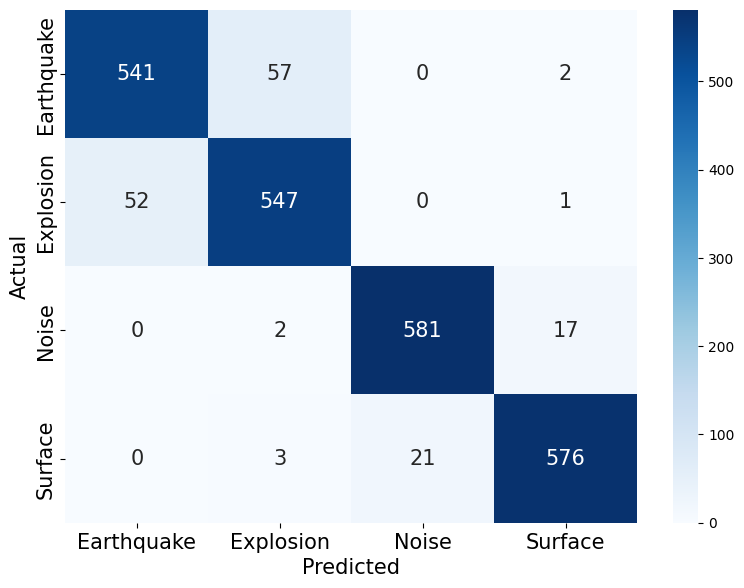

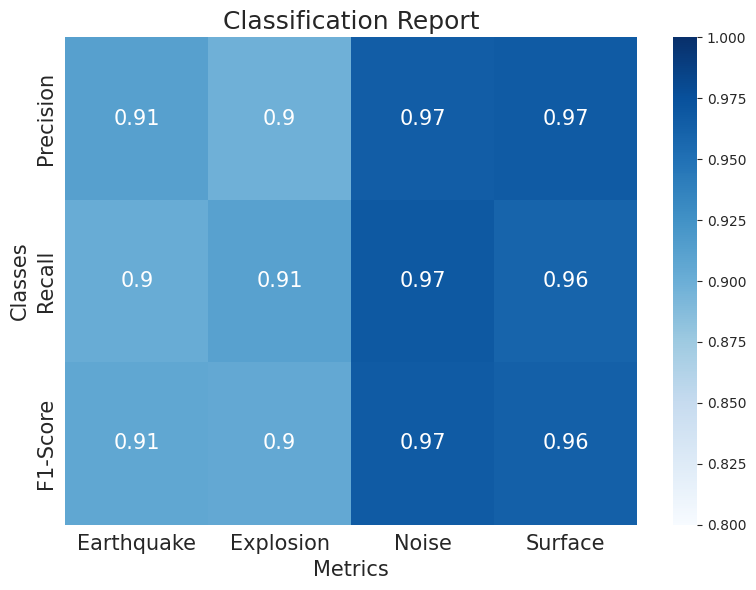

In [23]:
## plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)
plot_classification_report(report)

## Computing the feature importance

Feature importance refers to techniques that assign scores to input features based on their relevance in predicting the target variable. Understanding feature importance helps in interpreting models, reducing dimensionality, and improving model performance by focusing on the most impactful features.

In Random Forests, feature importance is calculated based on how much each feature contributes to reducing the impurity (e.g., Gini impurity or entropy) of the nodes in the decision trees. During training, each tree in the forest is built using a subset of the data and a random selection of features. The importance of a feature is determined by measuring the decrease in impurity that it causes when used for splitting nodes in the tree. Features that lead to large impurity decreases across all trees in the forest are considered more important, as they play a significant role in the model's ability to make accurate predictions. These importance scores are then averaged across all trees to determine the final importance of each feature, which can be used to understand the relative contribution of different features to the model's performance.

## We will compute the feature importance scores 10 times and average the results for final importance estimation. (It will take 5 - 7 minutes)

In [24]:
num_iter = 10
f_imp = []

for i in tqdm(range(num_iter)):

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000})
    X_resampled, y_resampled = rus.fit_resample(temp_X, y)

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num = label_encoder.fit_transform(y_resampled)


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_num, test_size=0.2, stratify = y_num)

    # Perform randomized grid search cross-validation
    best_model.fit(X_train, y_train)


    f_imp.append(best_model.feature_importances_)

100%|██████████| 10/10 [06:27<00:00, 38.75s/it]


## Plotting the feature importance

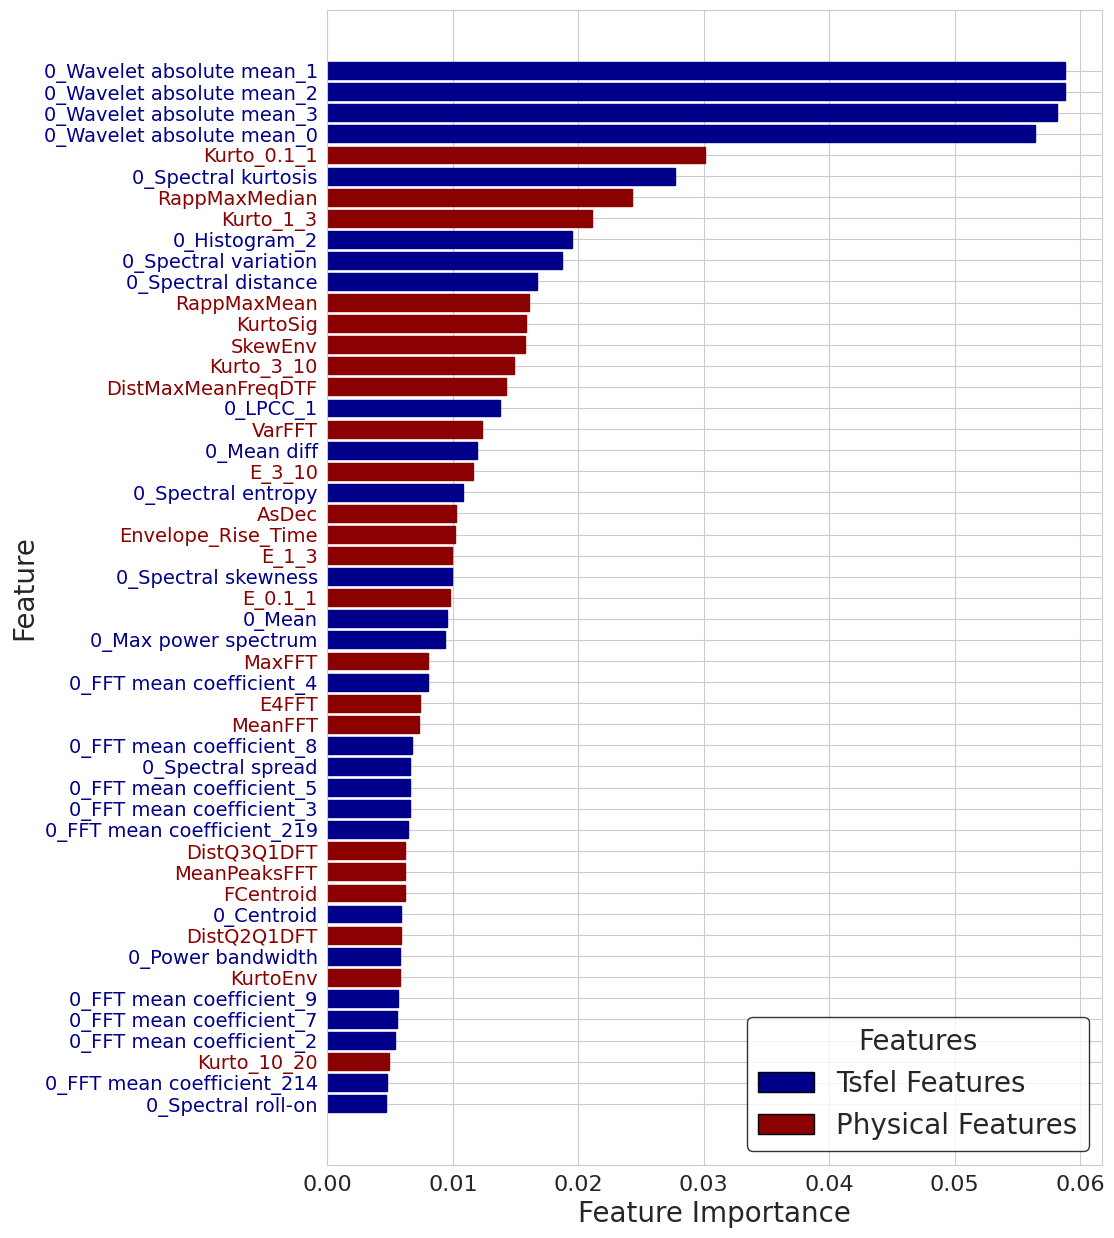

In [25]:
## Averaging the feature importance. 
final_imp = np.mean(f_imp, axis = 0)
features = X_train.columns.values
feature_colors = ['darkred']*49+['darkblue']*(len(features)-49)  # red for physical and blue for tsfel features. 

## Removing the 0 from the starting of each feature name
## the second argument in split specifies the maxsplit, the amount of times the split will be performed. 
#feature_names = np.hstack([features[0:49],[features[49:][i].split('_', 1)[1] for i in range(len(features[49:]))]])




# Set rc parameters for font size
plt.rcParams['xtick.labelsize'] = 16  # Font size for xtick labels
plt.rcParams['ytick.labelsize'] = 20  # Font size for ytick labels



# Sample feature importances and feature labels
feature_importances = final_imp
feature_labels = features

# Sort feature importances and feature labels together
sorted_indices = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k], reverse=True)
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_labels = [feature_labels[i] for i in sorted_indices]
colors = [feature_colors[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 15))
bars = plt.barh(sorted_feature_labels[0:50], sorted_feature_importances[0:50])

# Color bars to match yticklabels
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Color yticklabels and increase font size
for label, color in zip(plt.gca().get_yticklabels(), colors):
    label.set_color(color)
    #label.set_fontsize(20)  # Set desired font size here

# Create legend handles and labels
legend_handles = [plt.Rectangle((0,0),1,1, color='darkblue', ec='black'), plt.Rectangle((0,0),1,1, color='darkred', ec='black')]
legend_labels = ['Tsfel Features', 'Physical Features']

plt.legend(legend_handles, legend_labels, title='Features', title_fontsize=20, frameon=True, fontsize = 20, facecolor='white', edgecolor='black')

plt.xlabel('Feature Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
#plt.title('Top 50 Feature Importances', fontsize=20)
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top

# Set y-axis tick label size
plt.yticks(fontsize=14)

plt.show()





## Performance variation with the cumulative number of most important features
The performance of a machine learning model often varies with the number of features used, especially when considering only the most important features. Initially, as more important features are included, the model's performance tends to improve because these features contain valuable information for making predictions. However, there is a point where adding more features may lead to overfitting, where the model starts to learn noise in the data rather than true patterns, causing a drop in performance on unseen data. Therefore, it is important to find the right balance of features to maximize performance without overfitting. 

In [26]:
## based on the X_train and X_test computed previously. They should contain 2400 and 600 events per class respectively. 
sorted_feature_labels = [features[i] for i in sorted_indices]


## list to store the results with each iteration. 
results_dict = []


## list to store the computational time with each iteration. 
compute_time = []



for i in tqdm(range(1, len(sorted_feature_labels), 20)):
    selected_features = sorted_feature_labels[0:i]
    X_temp_train = X_train[selected_features].copy()
    X_temp_test = X_test[selected_features].copy()
    
    
    ## computing the model fitting time with increasing number of features
    i_time = time.time()
    ## assuming the hyperparameter tuning is not required as the change in performance is minimal. 
    best_model.fit(X_temp_train, y_train)
    compute_time.append(time.time() - i_time)
    
    ## predicting the result. 
    y_pred = best_model.predict(X_temp_test)
    results_dict.append(classification_report(y_test, y_pred, output_dict=True))


100%|██████████| 15/15 [06:24<00:00, 25.60s/it]


## Extracting results from the results dictionary

In [27]:
# Define the labels for surface events, explosions, and earthquakes
labels = ['3', '1', '0']

# Define a function to extract metrics based on the label and metric type
def extract_metric(results_dict, label, metric):
    return [results_dict[i][label][metric] for i in range(len(results_dict))]

# Extract accuracy, f1, precision, and recall for individual and group assessment
acc_features = [results_dict[i]['accuracy'] for i in range(len(results_dict))]
f1_features, prec_features, rec_features = (
    extract_metric(results_dict, 'macro avg', metric)
    for metric in ['f1-score', 'precision', 'recall']
)

# Extract f1, precision, and recall for surface events, explosions, and earthquakes
f1_su, prec_su, rec_su = (extract_metric(results_dict, '3', metric) for metric in ['f1-score', 'precision', 'recall'])
f1_exp, prec_exp, rec_exp = (extract_metric(results_dict, '1', metric) for metric in ['f1-score', 'precision', 'recall'])
f1_eq, prec_eq, rec_eq = (extract_metric(results_dict, '0', metric) for metric in ['f1-score', 'precision', 'recall'])


## Plotting the figure

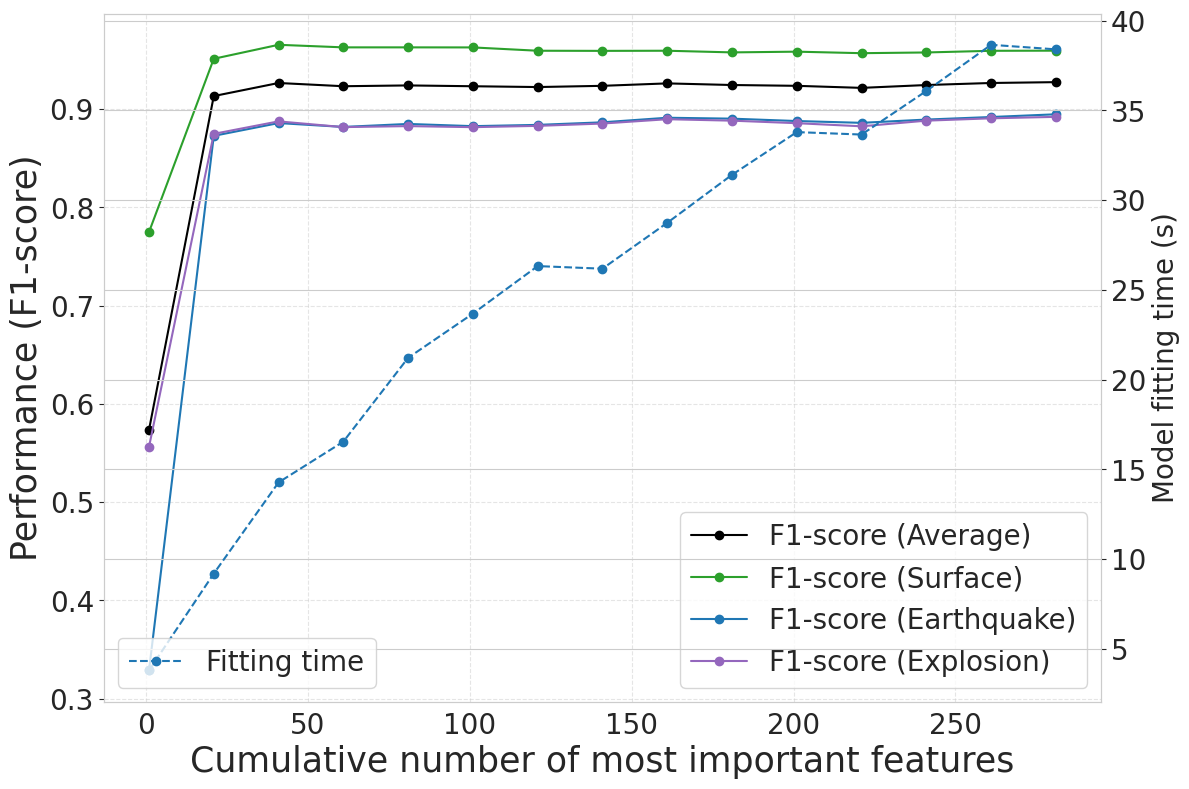

In [28]:
# Create a figure and axis for the main plot
fig, ax = plt.subplots(figsize=[12, 8])



cb_palette = ['#1f77b4','#9467bd',   '#d62728',  '#2ca02c',  ]


# Main plot
ax.plot(np.arange(1, len(sorted_feature_labels), 20), f1_features, marker='o', label='F1-score (Average)', color='k', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 20), f1_su, marker='o', label='F1-score (Surface)', color= '#2ca02c', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 20), f1_eq, marker='o', label='F1-score (Earthquake)', color='#1f77b4', linestyle='-')
ax.plot(np.arange(1, len(sorted_feature_labels), 20), f1_exp, marker='o', label='F1-score (Explosion)', color= '#9467bd', linestyle='-')
#ax.plot(np.arange(1, len(sorted_feature_labels), 10), f1_features, marker='o', label='F1-score', color=colors(0), linestyle='-')


#ax.plot(np.arange(len(f1_features)), acc_features, marker='s', label='Accuracy', color=colors(1), linestyle='--')
#ax.plot(np.arange(len(f1_features)), prec_features, marker='^', label='Precision', color=colors(2), linestyle='-.')
#ax.plot(np.arange(len(f1_features)), rec_features, marker='d', label='Recall', color=colors(3), linestyle=':')

ax.set_xlabel('Cumulative number of most important features', fontsize=25)
ax.set_ylabel('Performance (F1-score)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid(True, linestyle='--', alpha=0.5)
#ax.set_title('Performance Metrics vs. Number of Features', fontsize=25)


ax1 = ax.twinx()
ax1.plot(np.arange(1, len(sorted_feature_labels), 20), compute_time, marker = 'o', ls = '--', label = 'Fitting time')
ax1.set_ylabel('Model fitting time (s)', fontsize = 20)
ax.legend(fontsize= 20, loc='lower right')
ax1.legend(fontsize = 20, loc = 'lower left')

plt.tight_layout()
plt.show()


## Visualizing the distribution of most important features for each class

The most important tsfel features are found to be related to "Wavelet absolute means". 


we are convolving our input signal with ricker wavelet at different scales. Different scales correspond to different widths of the ricker wavelet which capture the information in different frequency bands. And then we average the values for each scale and take their absolute. The above code uses scipy’s ricker wavelet, for which following is true - 

The relationship between central frequency of each wavelet and scale of each wavelet can be given by - 

Fc = 2 * pi / (a * sqrt(3))

So here are the frequencies for each scale - 

- 0 - 3.63,
- 1 - 1.81,
- 2 - 1.21,
- 3 - 0.91,
- 4 - 0.73,
- 5 - 0.61,
- 6 - 0.52,
- 7 - 0.45,
- 8 - 0.40,
- 9 - 0.36


Only the first four scales were found to be the most important in classification of the events. 


/tmp/ipykernel_2420755/4313381.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df >= df.quantile(lower_quantile)) &
/tmp/ipykernel_2420755/4313381.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df <= df.quantile(upper_quantile))


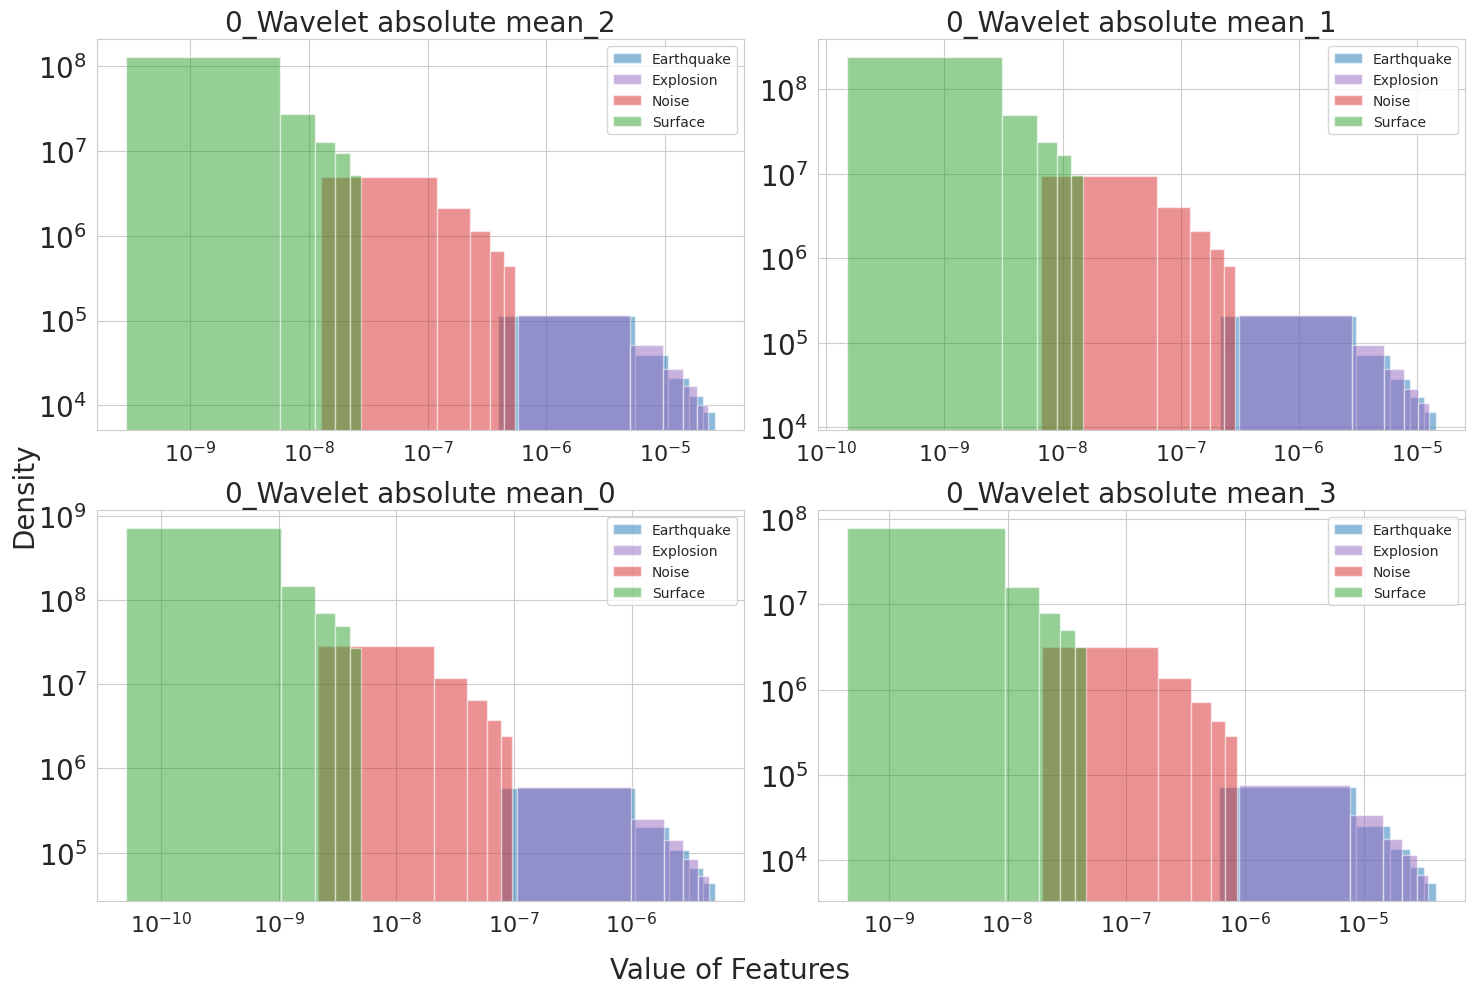

In [32]:
no_df = features_noise_tsfel
eq_df = features_earthquake_tsfel
su_df = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface']
exp_df = features_explosion_tsfel

filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


# Define a function for histogram plotting
def plot_histogram(ax, feature_data, label, color, num_bins, title):
    ax.hist(x=feature_data, bins=num_bins, density=True, color=color, alpha=0.5, label=label)
    ax.legend()
    ax.set_title(title, fontsize=20)

# Define common parameters
num_bins = 5
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[15, 10])

# Define features and labels
features = {
    '0_Wavelet absolute mean_2': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    '0_Wavelet absolute mean_1': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    '0_Wavelet absolute mean_0': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    '0_Wavelet absolute mean_3': [filtered_eq, filtered_exp, filtered_no, filtered_su]
}
labels = ['Earthquake', 'Explosion', 'Noise', 'Surface']
colors = ['#1f77b4', '#9467bd', '#d62728',  '#2ca02c']

# Iterate over features and plot histograms
for idx, (feature, (filtered_eq, filtered_exp, filtered_no, filtered_su)) in enumerate(features.items()):
    row = idx // 2
    col = idx % 2
    plot_histogram(ax[row, col], filtered_eq[feature].values, labels[0], colors[0], num_bins, feature)
    plot_histogram(ax[row, col], filtered_exp[feature].values, labels[1], colors[1], num_bins, feature)
    plot_histogram(ax[row, col], filtered_no[feature].values, labels[2], colors[2], num_bins, feature)
    plot_histogram(ax[row, col], filtered_su[feature].values, labels[3], colors[3], num_bins, feature)
    ax[row,col].set_xscale('log')
    ax[row,col].set_yscale('log')
    
fig.supylabel('Density', fontsize=20)
fig.supxlabel('Value of Features', fontsize=20)
fig.tight_layout()
plt.show()


/tmp/ipykernel_2420755/4313381.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df >= df.quantile(lower_quantile)) &
/tmp/ipykernel_2420755/4313381.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  (df <= df.quantile(upper_quantile))


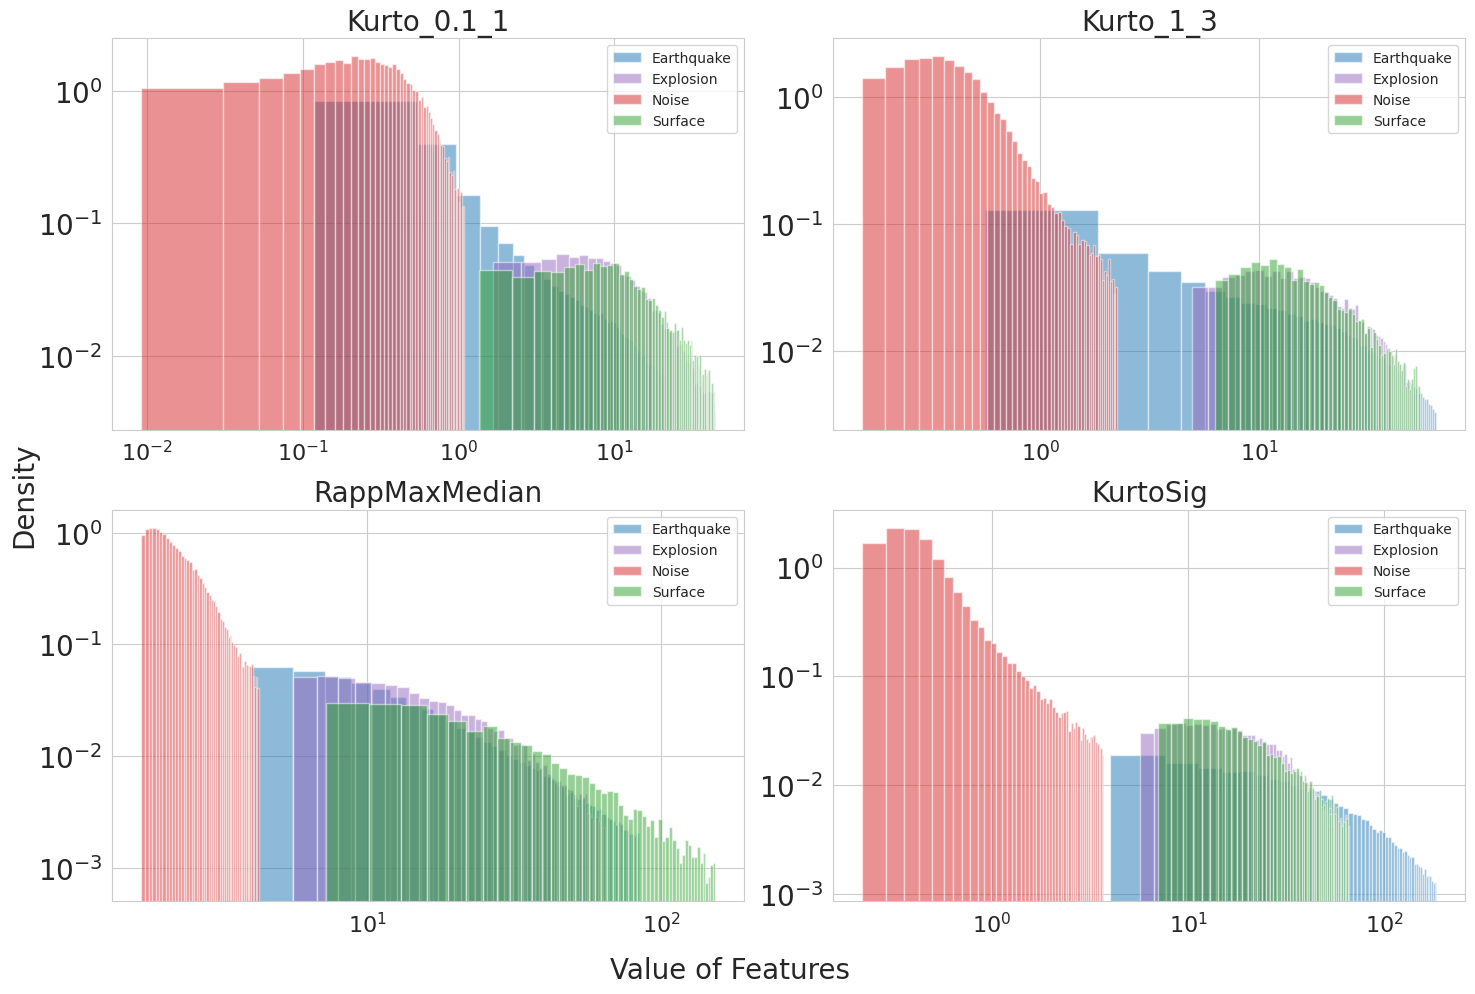

In [33]:
no_df = features_noise_physical
eq_df = features_earthquake_physical
su_df = features_exotic_physical[features_exotic_physical['source'] == 'surface']
exp_df = features_explosion_physical

filtered_no = interquartile(no_df)
filtered_su = interquartile(su_df)
filtered_eq = interquartile(eq_df)
filtered_exp = interquartile(exp_df)


# Define a function for histogram plotting
def plot_histogram(ax, feature_data, label, color, num_bins, title):
    ax.hist(x=feature_data, bins=num_bins, density=True, color=color, alpha=0.5, label=label)
    ax.legend()
    ax.set_title(title, fontsize=20)

# Define common parameters
num_bins = 50
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[15, 10])

# Define features and labels
features = {
    'Kurto_0.1_1': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'Kurto_1_3': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'RappMaxMedian': [filtered_eq, filtered_exp, filtered_no, filtered_su],
    'KurtoSig': [filtered_eq, filtered_exp, filtered_no, filtered_su]
}
labels = ['Earthquake', 'Explosion', 'Noise', 'Surface']
colors = ['#1f77b4', '#9467bd', '#d62728',  '#2ca02c']

# Iterate over features and plot histograms
for idx, (feature, (filtered_eq, filtered_exp, filtered_no, filtered_su)) in enumerate(features.items()):
    row = idx // 2
    col = idx % 2
    plot_histogram(ax[row, col], filtered_eq[feature].values, labels[0], colors[0], num_bins, feature)
    plot_histogram(ax[row, col], filtered_exp[feature].values, labels[1], colors[1], num_bins, feature)
    plot_histogram(ax[row, col], filtered_no[feature].values, labels[2], colors[2], num_bins, feature)
    plot_histogram(ax[row, col], filtered_su[feature].values, labels[3], colors[3], num_bins, feature)
    #ax[row, col].set_xlim(filtered_eq[feature].quantile(0.001), filtered_eq[feature].quantile(0.9))
    ax[row,col].set_xscale('log')
    ax[row,col].set_yscale('log')
    
    
fig.supylabel('Density', fontsize=20)
fig.supxlabel('Value of Features', fontsize=20)
fig.tight_layout()
plt.show()


## Downloading the metadata information for the events



This will help us to understand more information about each event such as origin time, epicenter and hypocenteral locations. This will also help us to extract manual features such as hour of the day, day of the week and month of the year. The metadata information of over 200k events is relatively large file, so we are going to download it from the zenodo

In [34]:
doi = '10.5281/zenodo.11218078'  #Downloading tsfel features for 150s length
# Download files from the Zenodo record
files = zenodo_get([doi])


Title: Metadata information for the events used in Ni et al. (2023)
Keywords: 
Publication date: 2024-05-20
DOI: 10.5281/zenodo.11218078
Total size: 57.3 MB

Link: https://zenodo.org/record/11218078/files/noise_metadata.csv   size: 4.9 MB

Checksum is correct. (4deaf6df52fcd669606efb0b95192780)

Link: https://zenodo.org/record/11218078/files/comcat_metadata.csv   size: 51.0 MB

Checksum is correct. (18f43b68d3df4944f7a857c2cdc52781)

Link: https://zenodo.org/record/11218078/files/exotic_metadata.csv   size: 1.4 MB

Checksum is correct. (7bbae524cc6d33da3db3b95fd5b00f05)
All files have been downloaded.


## Merging the metadata information with the extracted features

In [35]:
# extracting the catalog
comcat_file_csv = pd.read_csv("comcat_metadata.csv")
exotic_file_csv = pd.read_csv("exotic_metadata.csv")
noise_file_csv = pd.read_csv("noise_metadata.csv")

# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']

# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp

df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq

df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no

df_su = X_scaled[X_scaled['source'] == 'surface']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su


new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Deleting the large files from directory

In [36]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)

## Extracting hour of the day, day of the week and month of the year
We will see if including these manual features would improve the model performance. The main intuition behind including these features is to improving the discrimination between earthquakes and explosions. The explosions always occur during the day. 

In [37]:
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 168444/168444 [00:01<00:00, 109151.55it/s]


## For each event, there are two kinds of labels, USGS ANSS source label and PNSN source label. The PNSN first reviews events and assign a label that include various varieties of earthquakes, explosions and surface events, these labels are then merged into categories of earthquakes and explosions

Text(0.5, 0, 'Labels assigned by PNSN')

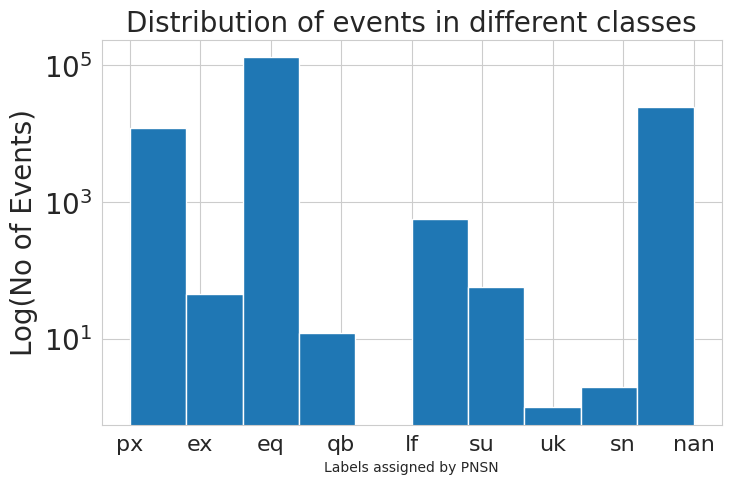

In [38]:
plt.figure(figsize = [8, 5])
plt.hist(X_final['source_type_pnsn_label'].astype('str'), align = 'mid')

plt.yscale('log')
plt.title('Distribution of events in different classes', fontsize = 20)
plt.ylabel('Log(No of Events)', fontsize = 20)
plt.xlabel('Labels assigned by PNSN')

### Explanation of PNSN labels


- px - probable blast , 'explosion' (USGS)
- ex - confirmed explosion, 'explosion' (USGS)
- eq - earthquake, 'earthquake' (USGS)
- qb - quarry blast, 'explosion' (USGS)
- lf - low frequency earthquakes (USGS)
- su - surface event, 'Surface event' (USGS)
- uk - unknown, 'Earthquake' (USGS)
- sn - 
- nan - noise is not a part of pnsn label



In this case, we will only select "px" for the explosions

## Training the model on 5000 random events (with replacement) per class and testing on the remaining dataset

In [39]:
## extracting metadata information for each kind of source along with features
## source_type_pnsn_label is more reliable label. 


# selecting all the earthquakes and their metadata information. 
a_eq = X_final[X_final['source_type_pnsn_label'] == 'eq']



## removing the ambiguous events, these are the events that were assigned as earthquakes by pnsn but labelled as
## explosion in USGS ANSS catalog. 
a_eq = a_eq[a_eq['source_type'] != 'explosion']


## selecting all the explosions specifically px, (which is mainly quarry blasts)
a_px = X_final[X_final['source_type_pnsn_label'] == 'px']
# removing the ambiguous events. 
a_px = a_px[a_px['source_type'] != 'earthquake']

a_su = X_final[X_final['source_type'] == 'surface event']
a_no = X_final[X_final['source_type'] == 'noise']



# Extract event IDs for each source type
eq_ids, px_ids, su_ids, no_ids = (
    np.unique(a['event_id'].values) for a in [a_eq, a_px, a_su, a_no]
)



## Specifying a random seed for the reproducibility. 
np.random.seed(123) 


## randomizing along the time. 
r1 = np.random.randint(0, len(eq_ids), 5000)
train_eq = eq_ids[r1]

## randomizing along the time. 
r2 = np.random.randint(0, len(px_ids), 5000)
train_px = px_ids[r2]

## randomizing along the time. 
r3 = np.random.randint(0, len(su_ids), 5000)
train_su = su_ids[r3]

## randomizing along the time
r4 = np.random.randint(0, len(no_ids), 5000)
train_no = no_ids[r4]



mask_eq = np.ones(eq_ids.shape, dtype = bool)
mask_eq[r1] = False

mask_px = np.ones(px_ids.shape, dtype = bool)
mask_px[r2] = False

mask_su = np.ones(su_ids.shape, dtype = bool)
mask_su[r3] = False

mask_no = np.ones(no_ids.shape, dtype = bool)
mask_no[r4] = False

test_eq = eq_ids[mask_eq]
test_px = px_ids[mask_px]
test_su = su_ids[mask_su]
test_no = no_ids[mask_no]



# concatenating training ids
all_train_ids = np.concatenate([train_eq,train_px, train_su, train_no])

# concatenating testing ids
all_test_ids = np.concatenate([test_eq,test_px, test_su, test_no])

# allocating event id as index
X_final.index = X_final['event_id'].values


# extracting training and testing values
X_train = X_final.loc[all_train_ids]
X_test = X_final.loc[all_test_ids]



Y_train = X_train['source_type'].values
Y_test = X_test['source_type'].values

## Model training and Evaluation

## Case 1: Without adding manual features

In [40]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
#x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
#x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)



## We will train the model on 5000 randomly selected samples and test on all the remaining

In [41]:
# initiating a random undersampler
# we have also specified a random state for reproducibility


# number of samples per each event. 
nus = 5000
rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)




RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_split=5, n_estimators=200, random_state=42)

## Plotting Trace wise performance

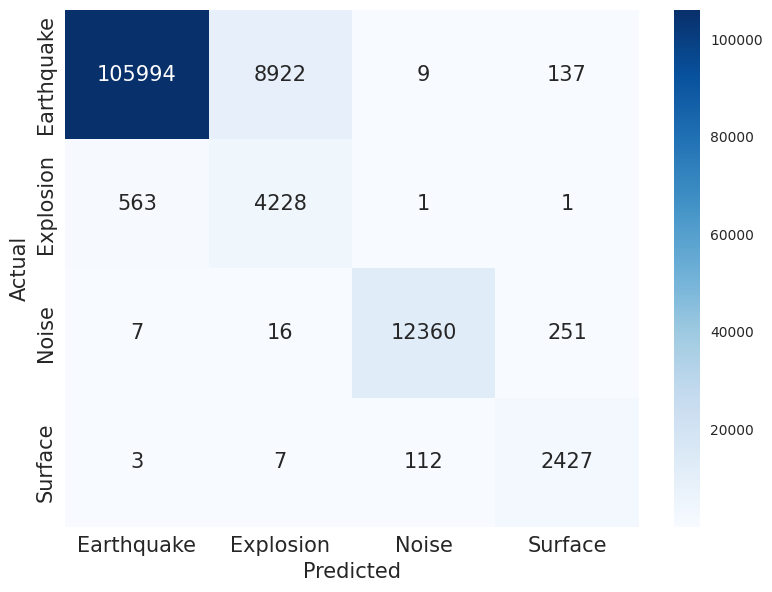

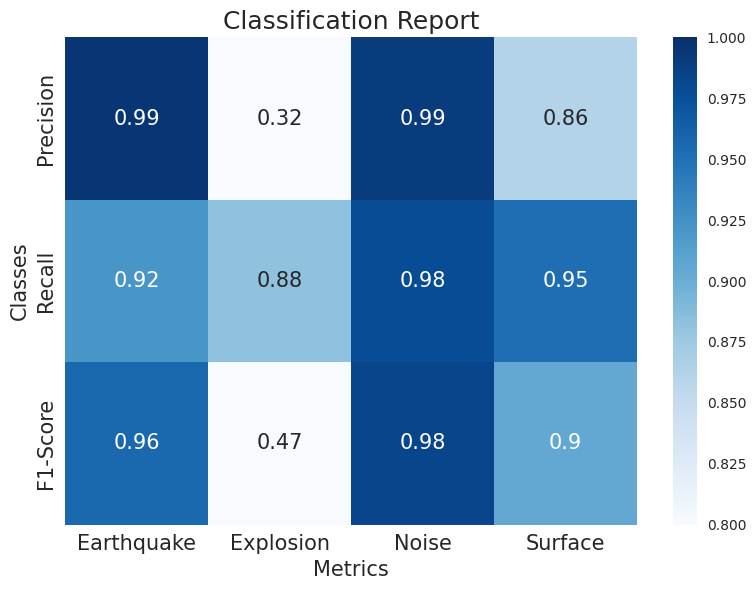

In [42]:
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(trace_cm_phy_tsf)


# Calculate the classification report
trace_report_phy_tsf = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(trace_report_phy_tsf)


## Plotting Event wise performance



The event wise performance is computed by assigning a label based on the maximum of the mean probabilities for each class over all the stations on which the event was recorded. 

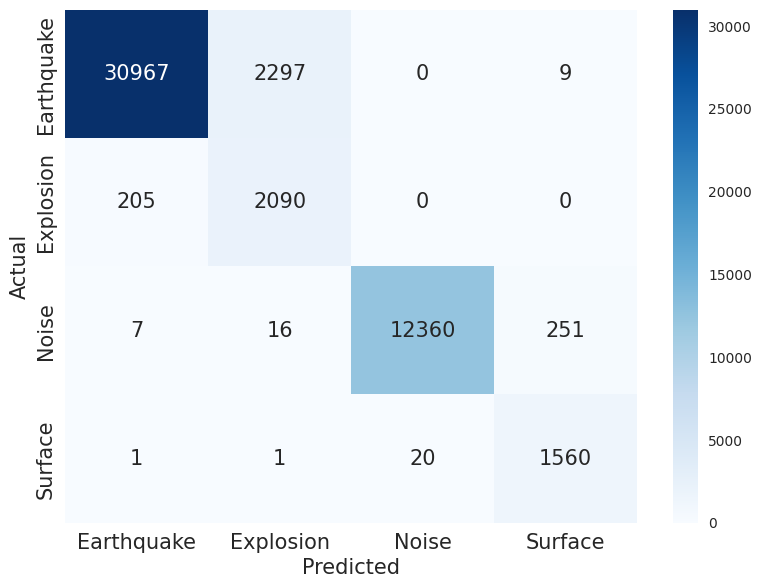

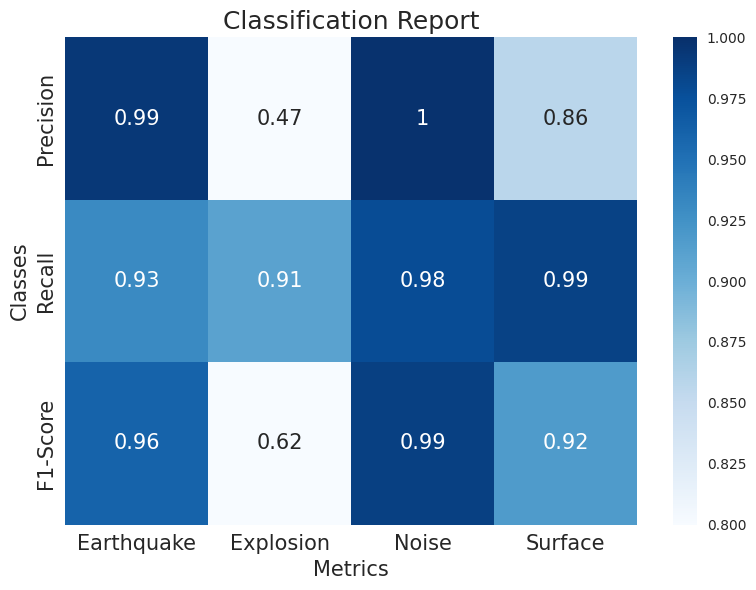

In [43]:
probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy_tsf = confusion_matrix(mean_labels, temp_class)
plot_confusion_matrix(cf_events_phy_tsf)


# Calculate the classification report
report_event_phy_tsf = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(report_event_phy_tsf)


## We can see that while model performance is good in general. There is a significant confusion between the explosions and earthquake. A lot more earthquakes are incorrectly identified as explosions. Now we will add manual features and see if it results in the improvement of the performace. 

## Case 2: Adding the manual features

Trace wise performance


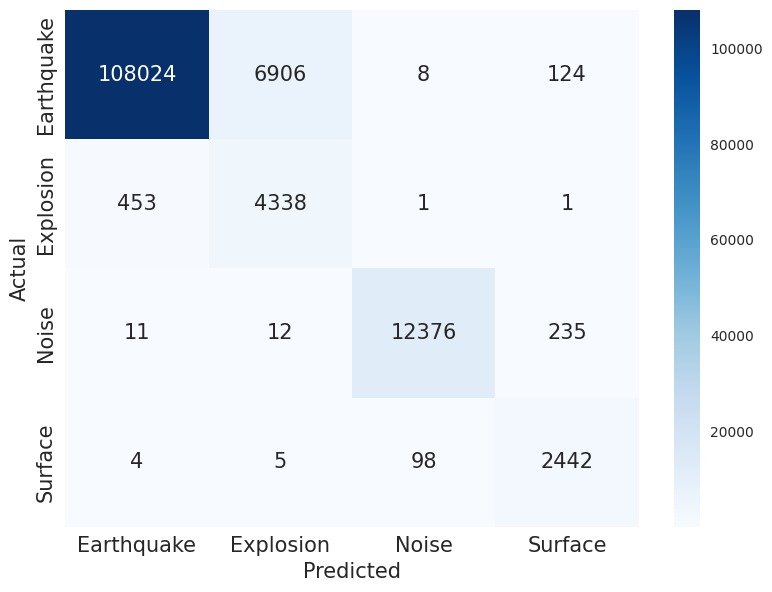

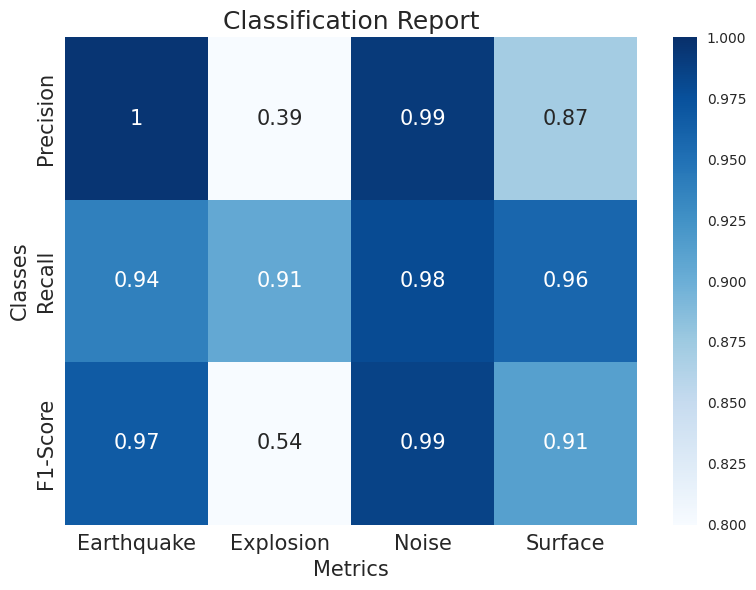

Event wise performance


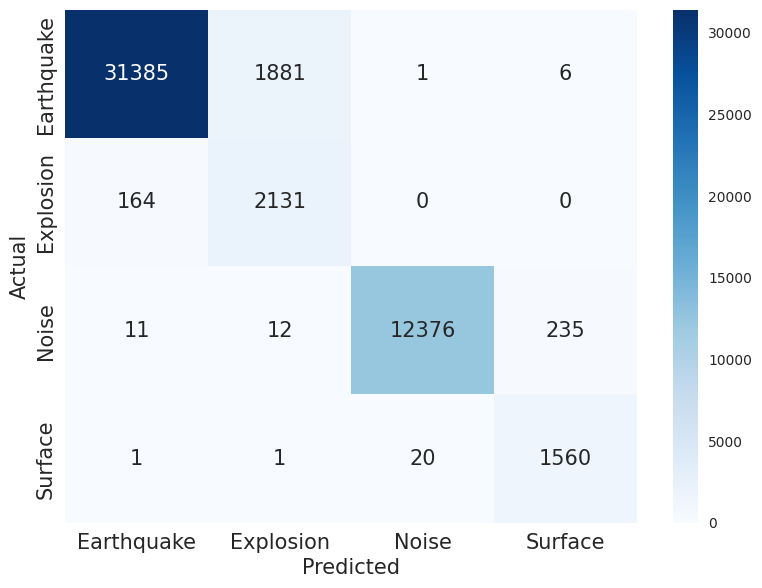

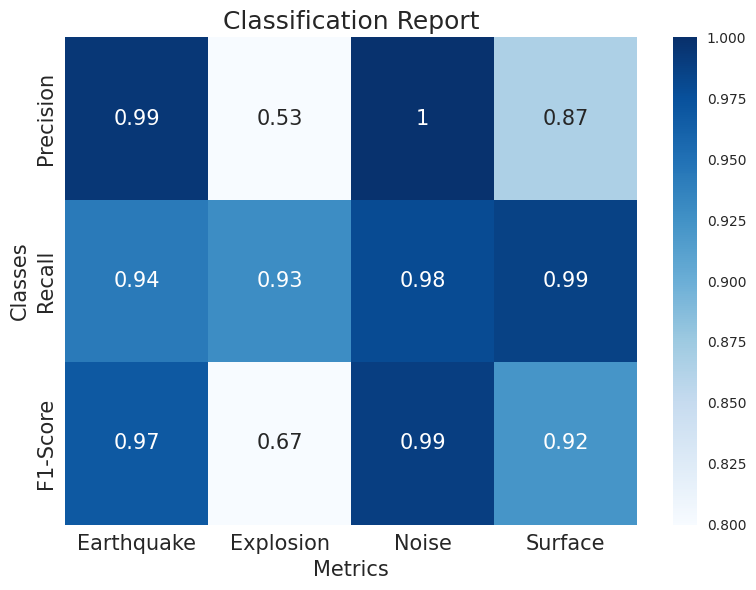

In [45]:
# Case 1: without adding anything manual
## Check the performance 
x_train = X_train.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_train = x_train.assign(hod=X_train['hour_of_day'].values, dow=X_train['day_of_week'].values, moy=X_train['month_of_year'].values)

x_test = X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
x_test = x_test.assign(hod=X_test['hour_of_day'].values, dow=X_test['day_of_week'].values, moy=X_test['month_of_year'].values)


# initiating a random undersampler
# we have also specified a random state for reproducibility


# number of samples per each event. 
nus = 5000
rus = RandomUnderSampler(sampling_strategy={'earthquake':nus, 'explosion':nus,'surface event':nus,'noise':nus}, random_state = 42)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(Y_test)


# randomly taking 5000 samples per class from the training dataset
X_resampled, y_resampled = rus.fit_resample(x_train, Y_train)


# Fit the LabelEncoder on the text labels and transform them to numeric labels
y_num_res = label_encoder.fit_transform(y_resampled)



best_model.class_weight  = None
best_model.fit(X_resampled, y_num_res)



print('Trace wise performance')
y_pred = best_model.predict(x_test)
plt.style.use('seaborn')
trace_cm_phy_tsf_man = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(trace_cm_phy_tsf_man)


# Calculate the classification report
trace_report_phy_tsf_man = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(trace_report_phy_tsf_man)





print('Event wise performance')

probs_all = best_model.predict_proba(x_test)

X_test['labelled'] = y_num_test
X_test['classified'] = y_pred
X_test['eq_probability'] = probs_all[:,0]
X_test['px_probability'] = probs_all[:,1]
X_test['no_probability'] = probs_all[:,2]
X_test['su_probability'] = probs_all[:,3]


mean_labels = X_test.groupby('event_id').mean()['labelled'].values
mean_ids = X_test.groupby('event_id').mean().index.values



mean_eq_prob = X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



cf_events_phy_tsf_man = confusion_matrix(mean_labels, temp_class)
plot_confusion_matrix(cf_events_phy_tsf_man)


# Calculate the classification report
report_event_phy_tsf_man = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(report_event_phy_tsf_man)



## The performance for explosions significantly improves from 0.62 to 0.67 after including manual features

## Testing again after removing potentially mislabeled events

### While analysts work hard to make sure the assigned source labels are as robust as possible, sometimes due to a very high similarity of the waveforms, large number of events, uncertainties in location, events might be mislabelled. This is particularly prevalent in the case of explosions. 

### One way to identify such potentially mislabeled events is to find the events that were misclassified with very high probability of over 80%. We will retest the model after removing such potentially mislabeled events to see if there is any improvements in the performance. 

In [46]:
# probabilities corresponding to misclassified events
misclassified_probs = temp_probs[np.where(mean_labels != temp_class)]

# classification provided to misclassified events
misclassified_class = temp_class[np.where(mean_labels != temp_class)]

# labels provided to misclassified events. 
misclassified_labels = mean_labels[np.where(mean_labels != temp_class)]

# event ids provided to misclassified events. 
misclassified_ids = mean_ids[np.where(mean_labels != temp_class)]

# event ids from misclassified events where mean probabilities exceed 0.8
misclassified_high_prob = misclassified_ids[np.where(misclassified_probs > 0.7)]

misclassified_X = X_test.loc[misclassified_high_prob]



In [47]:
new_X_test = X_test.drop(misclassified_high_prob)
new_x_test = new_X_test.iloc[:, 0:int(np.where(X_train.columns == 'serial_no')[0])]
new_x_test = new_x_test.assign(hod=new_X_test['hour_of_day'].values, dow=new_X_test['day_of_week'].values, moy= new_X_test['month_of_year'].values)

new_Y_test = new_X_test['source_type'].values

## Trace wise performance

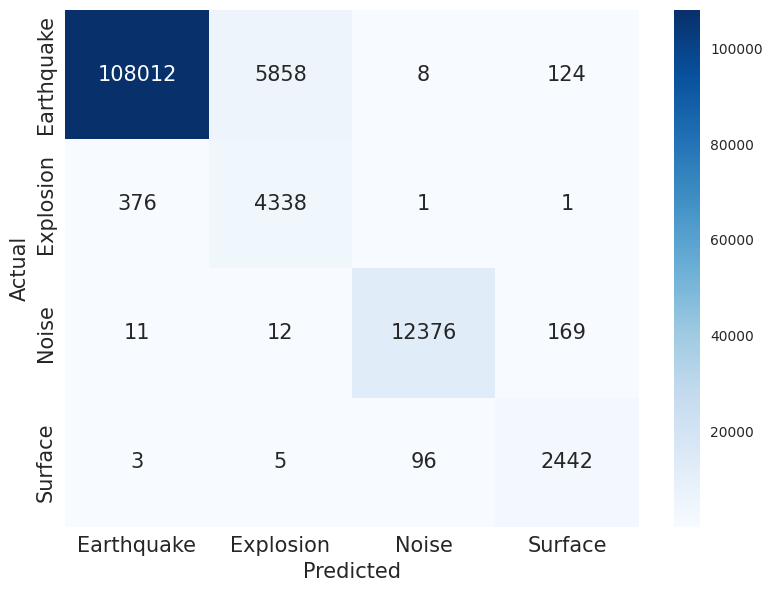

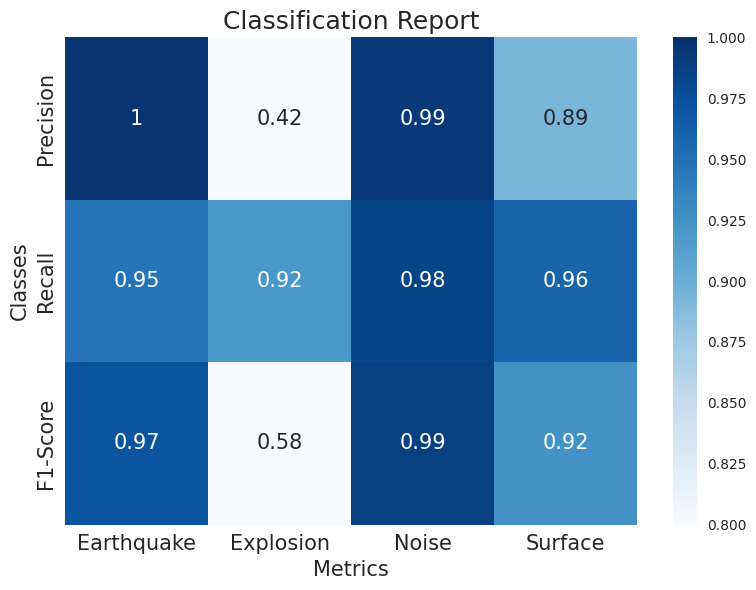

In [48]:
y_pred = best_model.predict(new_x_test)
plt.style.use('seaborn')


# Converting the textual labels into numerical labels
y_num_test = label_encoder.fit_transform(new_Y_test)

new_trace_cm_manual = confusion_matrix(y_num_test, y_pred)
plot_confusion_matrix(new_trace_cm_manual)

# Calculate the classification report
new_trace_report_manual = classification_report(y_num_test, y_pred, output_dict=True)
plot_classification_report(new_trace_report_manual)




## Event wise performance

/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


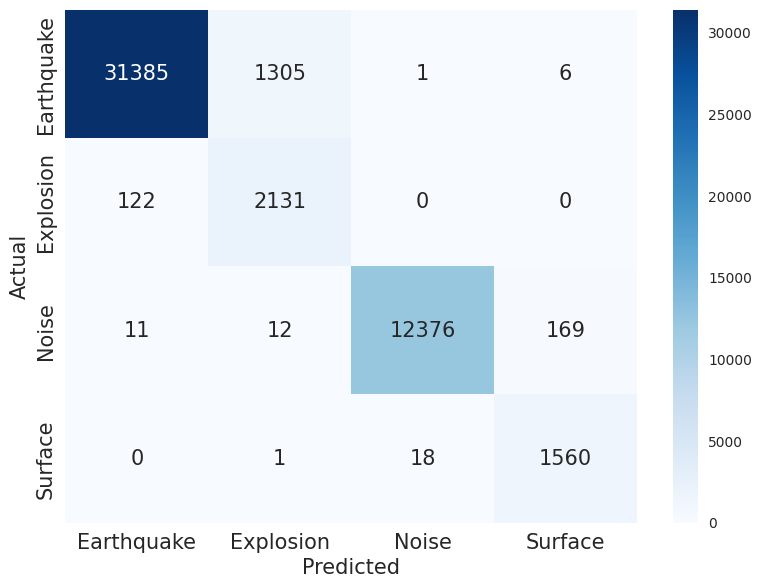

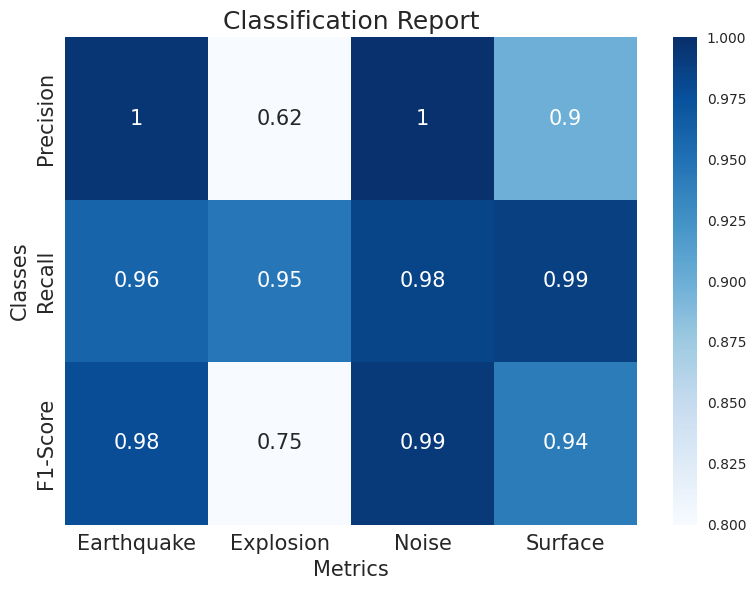

In [49]:
probs_all = best_model.predict_proba(new_x_test)

new_X_test['labelled'] = y_num_test
new_X_test['classified'] = y_pred
new_X_test['eq_probability'] = probs_all[:,0]
new_X_test['px_probability'] = probs_all[:,1]
new_X_test['no_probability'] = probs_all[:,2]
new_X_test['su_probability'] = probs_all[:,3]


mean_labels = new_X_test.groupby('event_id').mean()['labelled'].values
mean_ids = new_X_test.groupby('event_id').mean().index.values



mean_eq_prob = new_X_test.groupby('event_id').mean()['eq_probability'].values
mean_px_prob = new_X_test.groupby('event_id').mean()['px_probability'].values
mean_no_prob = new_X_test.groupby('event_id').mean()['no_probability'].values
mean_su_prob = new_X_test.groupby('event_id').mean()['su_probability'].values



temp_class = np.argmax(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)
temp_probs = np.max(np.vstack([mean_eq_prob, mean_px_prob, mean_no_prob, mean_su_prob]), axis = 0)



new_cf_events_manual = confusion_matrix(mean_labels, temp_class)
#new_cf_norm_manual = cf_events_manual/np.sum(cf_events_manual, axis = 1, keepdims = True)
plot_confusion_matrix(new_cf_events_manual)





# Calculate the classification report
new_report_event_manual = classification_report(mean_labels, temp_class, output_dict=True)
plot_classification_report(new_report_event_manual)


## Comparison of the performance

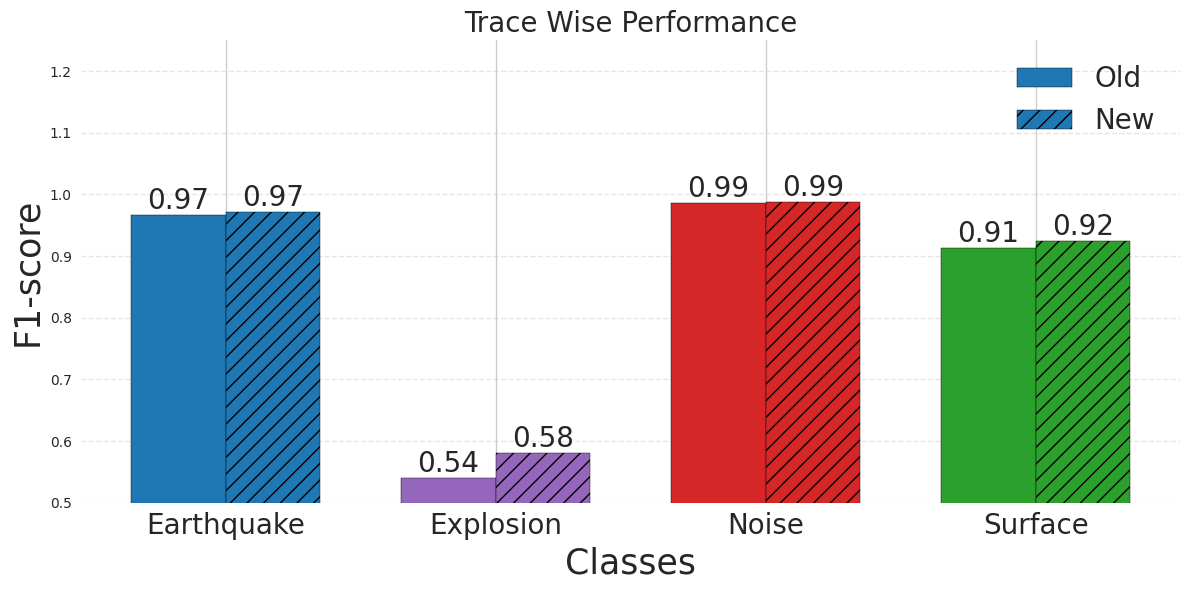

In [50]:
# Data for the first group
eq_trace_f1 = trace_report_phy_tsf_man['0']['f1-score']
exp_trace_f1 = trace_report_phy_tsf_man['1']['f1-score']
no_trace_f1 = trace_report_phy_tsf_man['2']['f1-score']
su_trace_f1 = trace_report_phy_tsf_man['3']['f1-score']

# Data for the second group
new_eq_trace_f1 = new_trace_report_manual['0']['f1-score']
new_exp_trace_f1 = new_trace_report_manual['1']['f1-score']
new_no_trace_f1 = new_trace_report_manual['2']['f1-score']
new_su_trace_f1 = new_trace_report_manual['3']['f1-score']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Plot the bars
# Colorblind-friendly palette
cb_palette = ['#1f77b4','#9467bd',   '#d62728',  '#2ca02c',  ]


plt.figure(figsize=(12, 6))
plt.bar(r1, [eq_trace_f1, exp_trace_f1, no_trace_f1, su_trace_f1], color= cb_palette, width=bar_width, edgecolor='k', label='Old')
plt.bar(r2, [new_eq_trace_f1, new_exp_trace_f1, new_no_trace_f1, new_su_trace_f1], color= cb_palette, hatch='//', width=bar_width, edgecolor='black', label='New')

# Add labels, title, and legend
plt.ylim(0.5,1.25)
plt.xlabel('Classes',  fontsize=25)
plt.ylabel('F1-score', fontsize=25)
plt.xticks([r + bar_width/2 for r in range(4)], ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=20)
#plt.title('F1-score by Class for Old and New', fontweight='bold', fontsize=14)
plt.legend(fontsize=20)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', ((p.get_x() + p.get_width() / 2), p.get_height()), ha='center', va='bottom', fontsize=20)

add_value_labels(plt.gca())

# Show plot
plt.title('Trace Wise Performance', fontsize = 20)
plt.tight_layout()
plt.show()


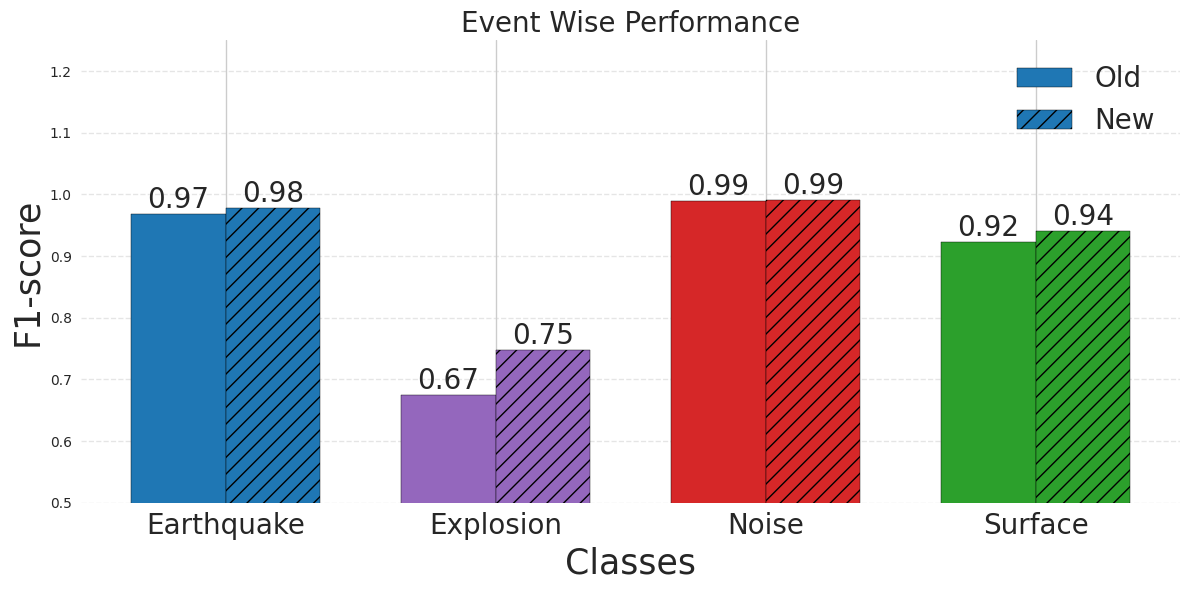

In [51]:
# Data for the first group
eq_trace_f1 = report_event_phy_tsf_man['0.0']['f1-score']
exp_trace_f1 = report_event_phy_tsf_man['1.0']['f1-score']
no_trace_f1 = report_event_phy_tsf_man['2.0']['f1-score']
su_trace_f1 = report_event_phy_tsf_man['3.0']['f1-score']

# Data for the second group
new_eq_trace_f1 = new_report_event_manual['0.0']['f1-score']
new_exp_trace_f1 = new_report_event_manual['1.0']['f1-score']
new_no_trace_f1 = new_report_event_manual['2.0']['f1-score']
new_su_trace_f1 = new_report_event_manual['3.0']['f1-score']

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(4)
r2 = [x + bar_width for x in r1]

# Plot the bars
plt.figure(figsize=(12, 6))
plt.bar(r1, [eq_trace_f1, exp_trace_f1, no_trace_f1, su_trace_f1], color= cb_palette, width=bar_width, edgecolor='black', label='Old')
plt.bar(r2, [new_eq_trace_f1, new_exp_trace_f1, new_no_trace_f1, new_su_trace_f1], color= cb_palette, hatch='//', width=bar_width, edgecolor='black', label='New')

# Add labels, title, and legend
plt.ylim(0.5, 1.25)
plt.xlabel('Classes',  fontsize= 25)
plt.ylabel('F1-score',  fontsize=25)
plt.xticks([r + bar_width/2 for r in range(4)], ['Earthquake', 'Explosion', 'Noise', 'Surface'], fontsize=20)
#plt.title('F1-score by Class for Old and New', fontweight='bold', fontsize=14)
plt.legend(fontsize=20)

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of each bar
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', ((p.get_x() + p.get_width() / 2), p.get_height()), ha='center', va='bottom', fontsize= 20)

add_value_labels(plt.gca())

# Show plot
plt.title('Event Wise Performance', fontsize = 20)
plt.tight_layout()
plt.show()


## So we manage to increase the performance of the model in the case of explosions from 0.62 to 0.75